In [1]:
import h5py
import os
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.utils.io_utils import HDF5Matrix
from keras.applications.imagenet_utils import preprocess_input
base_path = os.path.join('data')
train_path = os.path.join(base_path, 'food_c101_n10099_r64x64x3.h5')
test_path = os.path.join(base_path, 'food_test_c101_n1000_r64x64x3.h5')


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# for the error'HDF5Matrix' object has no attribute 'reshape', in the line FunctionTransformer(lambda x: x.reshape((x.shape[0],-1)), validate = False), 
# we need to add[:], behind the HDF5Matrix here.
#[:] is the array slice syntax for every element in the array.
X_train = HDF5Matrix(train_path, 'images_')[:]
y_train = HDF5Matrix(train_path, 'category_copy')[:]
test1 =HDF5Matrix(train_path,'category_names')
#test2 =HDF5Matrix(train_path,'subgroup')
print(X_train.shape)
print(X_train[0].min())
print(X_train[0].max())
print(y_train.shape)
print(test1.shape)
#print(len(test2))
print(test1[0],test1[1],test1[2])
#######################################
X_test = HDF5Matrix(test_path, 'images_')[:]
y_test = HDF5Matrix(test_path, 'category_')[:]
print(X_test.shape)
print(y_test.shape)
#print(len(y_test["category"]))

(1001, 64, 64, 3)
0
242
(1001, 101)
(101,)
b'apple_pie' b'baby_back_ribs' b'baklava'
(100, 64, 64, 3)
(100, 101)


In [3]:
y_test_cat = np.argmax(y_test,-1)
y_train_cat = np.argmax(y_train,-1)
#np.argmax  Returns the indices of the maximum values along an axis.

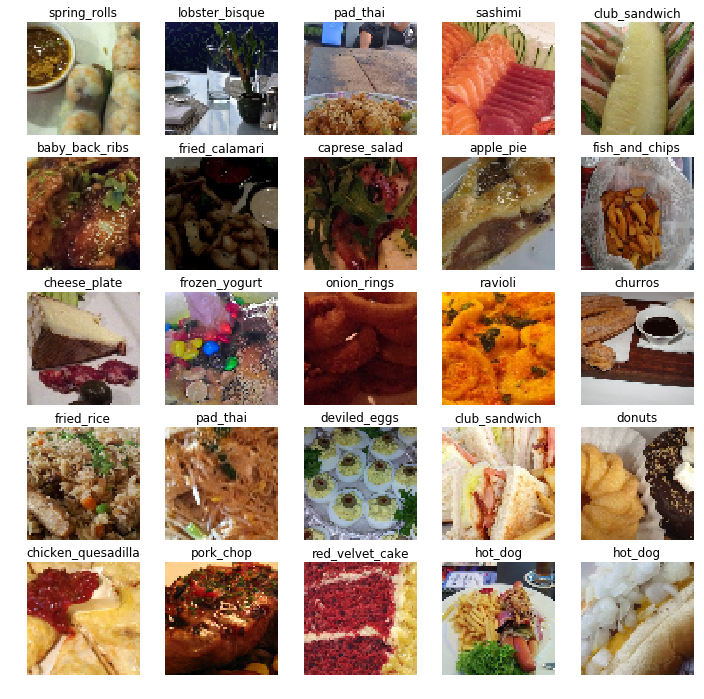

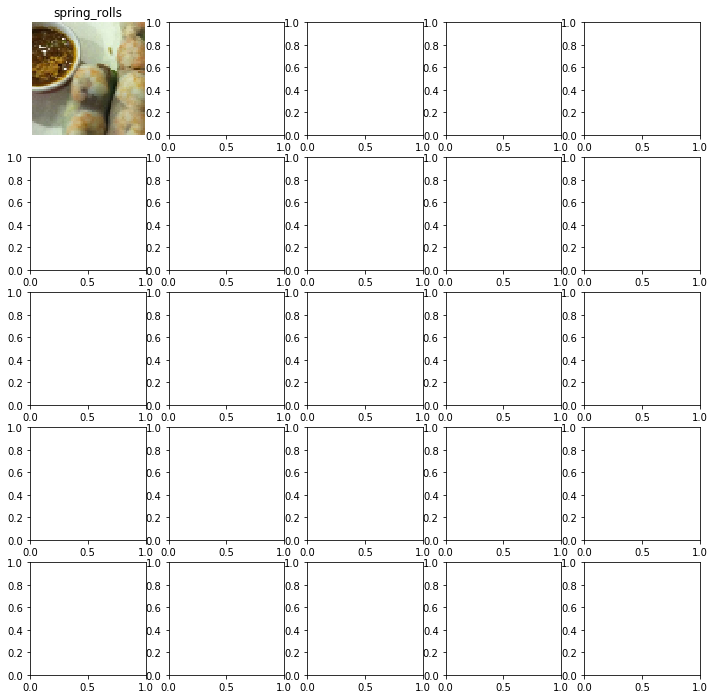

In [8]:
# show some images
#imshow cannot show images, add plt.show() at the end of code snippt

with h5py.File(train_path, 'r') as n_file:
    total_imgs = n_file['images'].shape[0]
    read_idxs = slice(2,100)
    im_data = n_file['images'][read_idxs]
    im_label = n_file['category'].value[read_idxs]
    label_names = [x.decode() for x in n_file['category_names'].value]
fig, m_ax = plt.subplots(5, 5, figsize = (12, 12))
for c_ax, c_label, c_img in zip(m_ax.flatten(), im_label, im_data):
    c_ax.imshow(c_img if c_img.shape[2]==3 else c_img[:,:,0], cmap = 'gray')
    c_ax.axis('off')
    c_ax.set_title(label_names[np.argmax(c_label)])
    plt.show()

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer, Normalizer
from sklearn.pipeline import make_pipeline
full_pipeline = make_pipeline(
    FunctionTransformer(lambda x: x.reshape((x.shape[0],-1)), validate = False), 
    Normalizer(),
    RandomForestClassifier()
)

### build the pipeline, include the randon forest classifier inside the pipleline
### difference between make_pipeline and pipeline
### This is a shorthand for the Pipeline constructor;
### it does not require, and does not permit, naming the estimators. 
### Instead, their names will be set to the lowercase of their types automatically.


In [12]:
%%time
full_pipeline.fit(X_train, y_train_cat)
#http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

Wall time: 905 ms


Pipeline(memory=None,
     steps=[('functiontransformer', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000001BC1878A8C8>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          validate=False)), ('normalizer', Normalizer(copy=True, norm='l2')), ('randomfo...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [13]:
# show the loss and accuracy in the process of training.
%time
import time
y_train_pred = full_pipeline.predict(X_train)
y_pred = full_pipeline.predict(X_test)
print(y_train_pred,y_pred)
print(time.time(),time.clock())
#time.time() shows that the wall-clock time has passed approximately one second
#time.clock() shows the CPU time spent on the current process is less than 1 microsecond. 
#time.clock() has a much higher precision than time.time().


Wall time: 0 ns
[33 53 92 ... 73 69 99] [ 1 21 33 21  1 15 47 36  0  1  5 70 61 23  3 72 99 96 82 44 66 65  4  8
  9 21  5  5 16  6 44  5 11 27  1  6  4 20 32  8 95 17 30  3 94 62  5  3
  2 64 85  1  2 19  8 98 22  2  3 24  5  6 42 88  4  6 12 10  2 26  9  1
 20 42  8 88  1  8 61 62 22 91 10  1 46  3 34  8 25  8 84 10 55 11  9 41
  3  9 24 29]
1524508332.236918 3.4117363720478884


#### The y_pred means the number of the predicted category in the test dataset which has 100 images and there are 100 numbers.

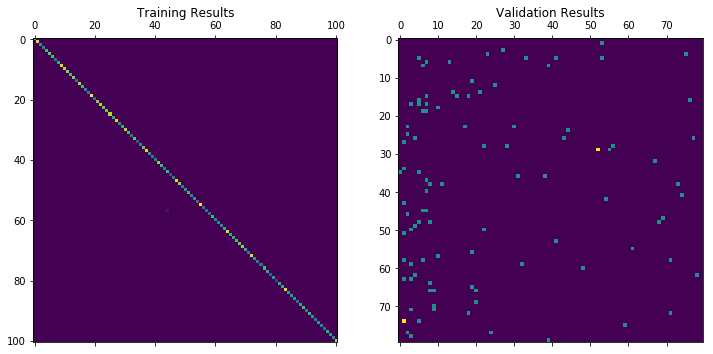

In [15]:
from sklearn.metrics import classification_report, classification
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
ax1.matshow(classification.confusion_matrix(y_train_cat, y_train_pred))
ax1.set_title('Training Results')
ax2.matshow(classification.confusion_matrix(y_test_cat, y_pred))
ax2.set_title('Validation Results')
plt.show()

In [16]:
# print out the classification report
print(classification_report(y_test_cat, y_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.00      0.00      0.00         1
          2       0.00      0.00      0.00         0
          3       0.00      0.00      0.00         1
          4       0.00      0.00      0.00         2
          5       0.17      0.25      0.20         4
          6       0.00      0.00      0.00         2
          8       0.00      0.00      0.00         2
          9       0.00      0.00      0.00         0
         10       0.00      0.00      0.00         0
         11       0.00      0.00      0.00         0
         12       0.00      0.00      0.00         1
         13       0.00      0.00      0.00         1
         15       0.00      0.00      0.00         0
         16       1.00      0.50      0.67         2
         17       1.00      0.33      0.50         3
         18       0.00      0.00      0.00         2
         19       0.00      0.00      0.00   

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## analysis for the classification_report 

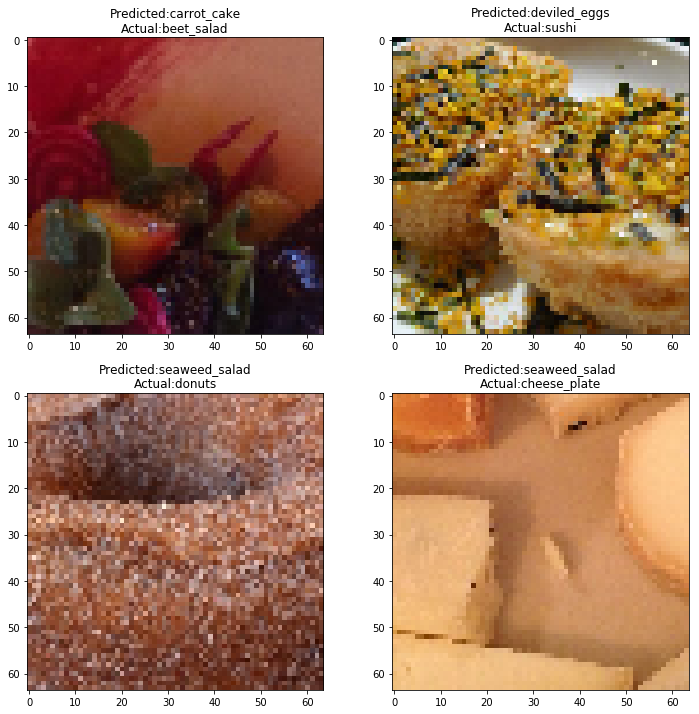

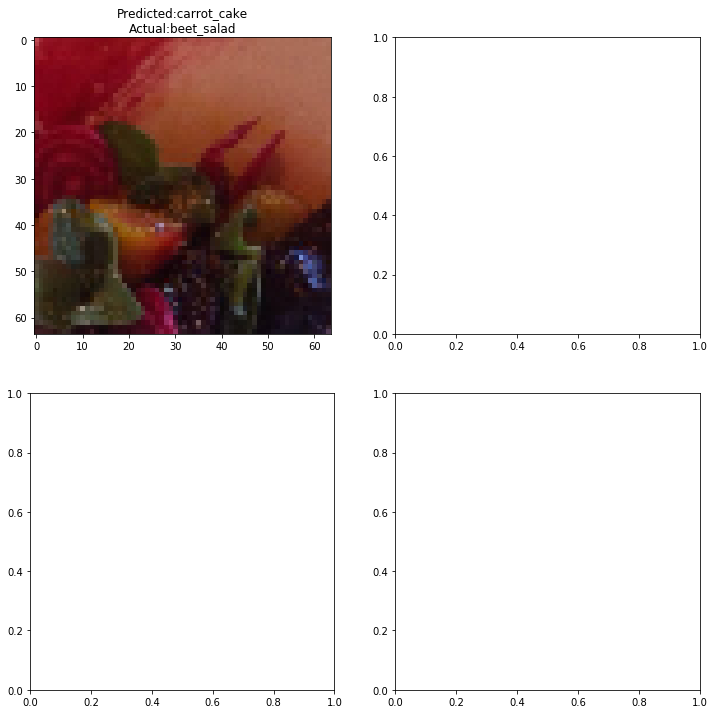

In [67]:
# visulize the prediction results
sample_imgs=50
with h5py.File(test_path, 'r') as n_file:
    total_imgs = n_file['images'].shape[0]
    read_idxs = slice(10,sample_imgs)
    im_data = n_file['images'][read_idxs]
    im_label = n_file['category'].value[read_idxs]
    label_names = [x.decode() for x in n_file['category_names'].value]
    
    
pred_label = full_pipeline.predict_proba(im_data)
fig, m_ax = plt.subplots(2, 2, figsize = (12, 12))

#for i in sample_imgs:
for c_ax, c_label, c_pred, c_img in zip(m_ax.flatten(), im_label, pred_label, im_data):
        
        c_ax.imshow(c_img if c_img.shape[2]==3 else c_img[:,:,0], cmap = 'gray')
        #plt.show()
        c_ax.axis('on')
        c_ax.set_title('Predicted:{}\nActual:{}'.format(label_names[np.argmax(c_pred)],
                                                  label_names[np.argmax(c_label)]))
        for i in range(4):
            plt.show()

    